In [856]:
#!/Tsan/bin/python
# -*- coding: utf-8 -*-

In [897]:
# Libraries to use
from __future__ import division 
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [858]:
# Import My own library for factor testing
import factorFilterFunctions as ff
#from config import *

In [859]:
%matplotlib inline

In [860]:
# basic stocl pool
ZZ500Weight = 'LZ_GPA_INDEX_CSI500WEIGHT.csv'
HS300Weight = 'LZ_GPA_INDEX_HS300WEIGHT.csv'

In [861]:
filenamePrice ='LZ_GPA_DERI_AdjustedPriceForward_20.csv'

In [862]:
# Factors
# Value factor
filenamePE='LZ_GPA_VAL_PE.csv'  # 市盈率
filenamePB='LZ_GPA_VAL_PB.csv'  # 市净率
filenamePS = 'LZ_GPA_VAL_PS.csv' # 市销率
filenamePCF = 'LZ_GPA_VAL_PC.csv' # 市现率

# Growth factor
filenameYOYGR = 'LZ_GPA_FIN_IND_QFA_YOYGR.csv'  # 单季度.营业总收入同比增长率(%)
filenameYOYNETPROFIT = 'LZ_GPA_FIN_IND_QFA_YOYNETPROFIT.csv' # 单季度.归属母公司股东的净利润同比增长率(%)
filenameYOYOCF = 'LZ_GPA_FIN_IND_YOYOCF.csv' # 同比增长率-经营活动产生的现金流量净额(%)
filenameYOYROE = 'LZ_GPA_FIN_IND_YOYROE.csv' # 同比增长率-净资产收益率(摊薄)(%)
filenameYOYBPS = 'LZ_GPA_FIN_IND_YOYBPS.csv' # 相对年初增长率-每股净资产(%)

# Financial factor
filenameCAPITALIZEDTODA = 'LZ_GPA_FIN_IND_CAPITALIZEDTODA.csv'  # 资本支出/折旧和摊销
filenameCASHRATIO = 'LZ_GPA_FIN_IND_CASHRATIO.csv' # 保守速动比率
filenameCASHTOLIQDEBT = 'LZ_GPA_FIN_IND_CASHTOLIQDEBT.csv' # 货币资金／流动负债
filenameOCFTODEBT = 'LZ_GPA_FIN_IND_OCFTODEBT.csv' # 经营活动产生的现金流量净额/负债合计
filenamePROFITTOOP = 'LZ_GPA_FIN_IND_PROFITTOOP.csv' # 利润总额／营业收入

# Momentum factor
filenameTRUEMOM = 'LZ_GPA_USR_MOM.csv' # 真动量
filenameMOM1M = 'LZ_GPA_DERI_Momentum_1M.csv' # 一月反转
filenameMOM3M = 'LZ_GPA_TURNOVER_TurnoverAvg_3M.csv' # 三月反转
filenamePVO = 'LZ_GPA_DERI_PVO.csv' # 一年偏度
filenameRV1Y = 'LZ_GPA_DERI_RealizedVolatility_1Y.csv' # 一年收益波动
filenameABNORMALVOLUME = 'LZ_GPA_DERI_NormalizedAbormalVolume.csv' # 归一化异常交易量
filenameSKEW = 'LZ_GPA_DERI_TSKEW.csv'# 偏度

# Volatility factor


# Liquidity factor
filenameTURNOVER1M = 'LZ_GPA_TURNOVER_TurnoverAvg_1M.csv' # 一月换手率均值
filenameAMOUNTAVG1M = 'LZ_GPA_DERI_AmountAvg_1M.csv'      # 三月换手率均值
filenameILLIQ = 'LZ_GPA_DERI_ILLIQ.csv'                   # 非流动性因子
filenameVOLUME = 'LZ_GPA_QUOTE_TVOLUME.csv'               # 成交量

In [863]:
filenameFCAP = 'LZ_GPA_VAL_A_FCAP.csv'

filenameBENCH = 'LZ_GPA_INDXQUOTE_CLOSE.csv'

In [864]:
# some useful parameters
startTime =  datetime.strptime('20120101', '%Y%m%d')
endTime = datetime.strptime('20161231', '%Y%m%d')
facNum = 5 # factor Num
path = ff.data_path # path
timeStampNum = 2500 # Number of time period
thresholdNum = 0.05  # thresholdNum to filter stocks by Nan's amount
HS300Index ='000300.SH' # HS300 index code
ZZ500Index = '000905.SH' #   ZZ500 index code

In [865]:
stockPool = pd.read_csv(path+ZZ500Weight,infer_datetime_format=True,parse_dates=[0],index_col=0).loc[startTime:endTime]
#stockPool = stockPool.iloc[-1].dropna(how='any').index.tolist()  # get today's ZX500 stock pool
stockPool1 = pd.read_csv(path+HS300Weight,infer_datetime_format=True,parse_dates=[0],index_col=0).loc[startTime:endTime]

In [866]:
stockPool = stockPool.dropna(how = 'all',axis =1).columns.tolist()
stockPool1 = stockPool1.dropna(how = 'all',axis =1).columns.tolist()

In [867]:
stockPool = list((set(stockPool1)|set(stockPool)))

In [868]:
len(stockPool)

1186

In [869]:
class dataCleaning():
    
    def __init__(self,data):
        self.__data = data
    #@property
    #def _constructor(self):
    #    return dataCleaning

    #@property
    #def _constructor_sliced(self):
    #   return SubclassedSeries
        
    def narrowData(self):
        return self.__data[stockPool].loc[startTime:endTime]
    
    def Normalize(self,narrowedData):
        dataWinsorized = narrowedData.copy()
        dataWinsorizedTrans = dataWinsorized.T
        MAD = 1.483*np.abs(dataWinsorizedTrans-dataWinsorizedTrans.median(skipna=True))
        return ((dataWinsorizedTrans - dataWinsorizedTrans.mean(axis=0, skipna=True))/dataWinsorizedTrans.std(axis=0, skipna=True)).T

In [870]:
PriceDF = pd.read_csv(path+filenamePrice,infer_datetime_format=True,parse_dates=[0],index_col=0)[stockPool].loc[startTime:endTime]

In [871]:
LFCAPData = np.log10(pd.read_csv(path+filenameFCAP,infer_datetime_format=True,parse_dates=[0],index_col=0))

PBData = pd.read_csv(path+filenamePB,infer_datetime_format=True,parse_dates=[0],index_col=0)

YOYBPSData = pd.read_csv(path+filenameYOYBPS,infer_datetime_format=True,parse_dates=[0],index_col=0)

AMOUNTAVG1MData = pd.read_csv(path+filenameAMOUNTAVG1M,infer_datetime_format=True,parse_dates=[0],index_col=0)

TURNOVER1MData = pd.read_csv(path+filenameTURNOVER1M,infer_datetime_format=True,parse_dates=[0],index_col=0)

PROFITOOPData = pd.read_csv(path+filenamePROFITTOOP,infer_datetime_format=True,parse_dates=[0],index_col=0)

benchmarkData = pd.read_csv(path+filenameBENCH,infer_datetime_format=True,parse_dates=[0],index_col=0)[ZZ500Index].loc[startTime:endTime]

In [872]:
#isinstance(dataCleaning(PBData).narrowData(),dataCleaning)

In [873]:
PBData = dataCleaning(PBData).Normalize(dataCleaning(PBData).narrowData())
LFCAPData  = dataCleaning(LFCAPData ).Normalize(dataCleaning(LFCAPData ).narrowData())
YOYBPSData = dataCleaning(YOYBPSData).Normalize(dataCleaning(YOYBPSData).narrowData())
AMOUNTAVG1MData = dataCleaning(AMOUNTAVG1MData).Normalize(dataCleaning(AMOUNTAVG1MData).narrowData())
TURNOVER1MData = dataCleaning(TURNOVER1MData).Normalize(dataCleaning(TURNOVER1MData).narrowData())
PROFITOOPData = dataCleaning(PROFITOOPData).Normalize(dataCleaning(PROFITOOPData).narrowData())

In [874]:
print PBData.shape[1], LFCAPData.shape[1], YOYBPSData.shape[1], AMOUNTAVG1MData.shape[1], TURNOVER1MData.shape[1], PROFITOOPData.shape[1]

1186 1186 1186 1186 1186 1186


In [875]:
#PROFITOOPData

In [876]:
PBData = PBData .loc[:, PBData .isnull().sum() < (len(PBData) * thresholdNum)]
LFCAPData  = LFCAPData .loc[:, LFCAPData .isnull().sum() < (len(LFCAPData) * thresholdNum)]
YOYBPSData = YOYBPSData .loc[:, YOYBPSData .isnull().sum() < (len(YOYBPSData) * thresholdNum)]
AMOUNTAVG1MData = AMOUNTAVG1MData .loc[:, AMOUNTAVG1MData .isnull().sum() < (len(AMOUNTAVG1MData) * thresholdNum)]
TURNOVER1MData = TURNOVER1MData .loc[:, TURNOVER1MData .isnull().sum() < (len(TURNOVER1MData) * thresholdNum)]
PROFITOOPData  = PROFITOOPData  .loc[:, PROFITOOPData .isnull().sum() < (len(PROFITOOPData ) * thresholdNum)]

PriceDF = PriceDF.loc[:, (PriceDF.isnull().sum() < (len(PriceDF) * thresholdNum))]

In [877]:
print PBData.shape[1], LFCAPData.shape[1], YOYBPSData.shape[1] ,AMOUNTAVG1MData.shape[1], TURNOVER1MData.shape[1], PROFITOOPData.shape[1]

1078 1093 1140 1086 1086 1143


In [878]:
len(list((DFcolumns(PBData)) & (DFcolumns(YOYBPSData))))

1078

In [879]:
def DFcolumns(df):
    return set(df.columns.tolist())

In [880]:
##
stkPool = list((DFcolumns(PBData)) & (DFcolumns(YOYBPSData)) & (DFcolumns(AMOUNTAVG1MData)) & (DFcolumns(TURNOVER1MData)) & (DFcolumns(PROFITOOPData))\
        & (DFcolumns(PriceDF)))
len(stkPool)

1071

In [881]:
#
def fillData(df,stkPool):
    return df[stkPool].fillna(method='ffill').fillna(method='bfill')

In [882]:
PBData = fillData(PBData,stkPool)
LFCAPData = fillData(LFCAPData,stkPool)
YOYBPSData = fillData(YOYBPSData,stkPool)
AMOUNTAVG1MData = fillData(AMOUNTAVG1MData,stkPool)
TURNOVER1MData = fillData(TURNOVER1MData,stkPool)
PROFITOOPData = fillData(PROFITOOPData,stkPool)

PriceDF = fillData(PriceDF,stkPool)

In [883]:
LFCAPData.shape

(1214, 1071)

In [884]:
returnDF = PriceDF.pct_change()[1:] 
returnOfBench = benchmarkData.pct_change()[1:]

In [885]:
activeReturnDF = returnDF .apply(lambda x: x - returnOfBench )
activeReturnDF.head().iloc[:,2].values

array([ 0.04409089, -0.01318374, -0.01007904, -0.01510373, -0.00549787])

In [886]:
factorReturn = pd.DataFrame(index = returnDF.index, columns = ['LFCA', 'PB', 'YOYBPS', 'AMOUNTAVG1MData', 'TURNOVER1M' ,\
                                                              'PROFITOOP'],data= None ,dtype =float)
factorPvalue =  pd.DataFrame(index = returnDF.index, columns = ['LFCA', 'PB', 'YOYBPS', 'AMOUNTAVG1MData', 'TURNOVER1M' ,\
                                                              'PROFITOOP'],data= None ,dtype =float)

In [887]:
specificReturn = pd.DataFrame(index = returnDF.index, columns = LFCAPData.columns ,dtype =float )

In [891]:
for date in returnDF.index:
    activeReturnSlice = activeReturnDF.loc[date]
    LFCAPDataSlice = LFCAPData.loc[date]
    PBDataSlice = PBData.loc[date]
    YOYBPSDataSlice = YOYBPSData.loc[date]
    AMOUNTAVG1MDataSlice = AMOUNTAVG1MData.loc[date]
    TURNOVER1MDataSlice = TURNOVER1MData.loc[date]
    PROFITOOPDataSlice = PROFITOOPData.loc[date]
    totalDF = pd.concat([LFCAPDataSlice,PBDataSlice,YOYBPSDataSlice,AMOUNTAVG1MDataSlice,TURNOVER1MDataSlice,PROFITOOPDataSlice],axis=1)
    #print totalDF,PBDataSlice
    result = sm.OLS(activeReturnSlice.T,totalDF ).fit()
    factorReturn . loc[date] = result.params.values
    factorPvalue . loc[date] = result.pvalues.values
    specificReturn .loc[date] = result.resid
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     2016-12-30 00:00:00   R-squared:                       0.091
Model:                             OLS   Adj. R-squared:                  0.085
Method:                  Least Squares   F-statistic:                     17.68
Date:                 Tue, 28 Mar 2017   Prob (F-statistic):           1.33e-19
Time:                         17:13:36   Log-Likelihood:                 3088.4
No. Observations:                 1071   AIC:                            -6165.
Df Residuals:                     1065   BIC:                            -6135.
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
2016-12-30 00:00:00     0.0008      0.001      1.482      0.139      -0.000       0.002
2016-12-30 00:00:00     0.0018      0.014      0.133      0.894      -0.025       0.028
2016-12-30 00:00:00    -0.0008      0.001     -0.868      0.386      -0.003       0.001
2016-12-30 00:00:00    -0.0016      0.000     -3.344      0.001      -0.003      -0.001
2016-12-30 00:00:00    -0.0038      0.001     -7.448      0.000      -0.005      -0.003
2016-12-30 00:00:00  4.907e-05      0.000      0.113      0.910      -0.001       0.001
==============================================================================
Omnibus:                      236.186   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2483.423
Skew:                           0.693   Prob(JB):                         0.00
Kurtosis:                      10.330   Cond. No.                         39.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [892]:
factorPvalue

,LFCA,PB,YOYBPS,AMOUNTAVG1MData,TURNOVER1M,PROFITOOP
LZ_GPA_DERI_AdjustedPriceForward_20-d,,,,,,
2012-01-05,2.597119e-23,1.972615e-01,0.965497,5.870558e-02,4.622353e-02,0.157070
2012-01-06,9.121577e-01,6.170598e-01,0.657364,7.934554e-03,3.620580e-03,0.340002
2012-01-09,8.277660e-03,2.772700e-09,0.854615,4.860796e-01,7.024959e-01,0.021382
2012-01-10,2.279392e-02,1.000300e-02,0.100935,7.820716e-01,1.531704e-03,0.180370
2012-01-11,3.131737e-05,3.527488e-04,0.273680,4.351636e-01,1.689099e-01,0.474584
2012-01-12,6.559955e-01,1.449947e-01,0.005982,9.122361e-01,5.667535e-02,0.017401
2012-01-13,2.474523e-23,6.136572e-04,0.241605,4.619089e-01,3.189210e-02,0.921379
2012-01-16,5.823584e-04,5.705310e-02,0.483391,1.226828e-01,3.487606e-02,0.386802
2012-01-17,5.461595e-01,3.259324e-04,0.680092,5.409221e-02,8.982581e-01,0.167009


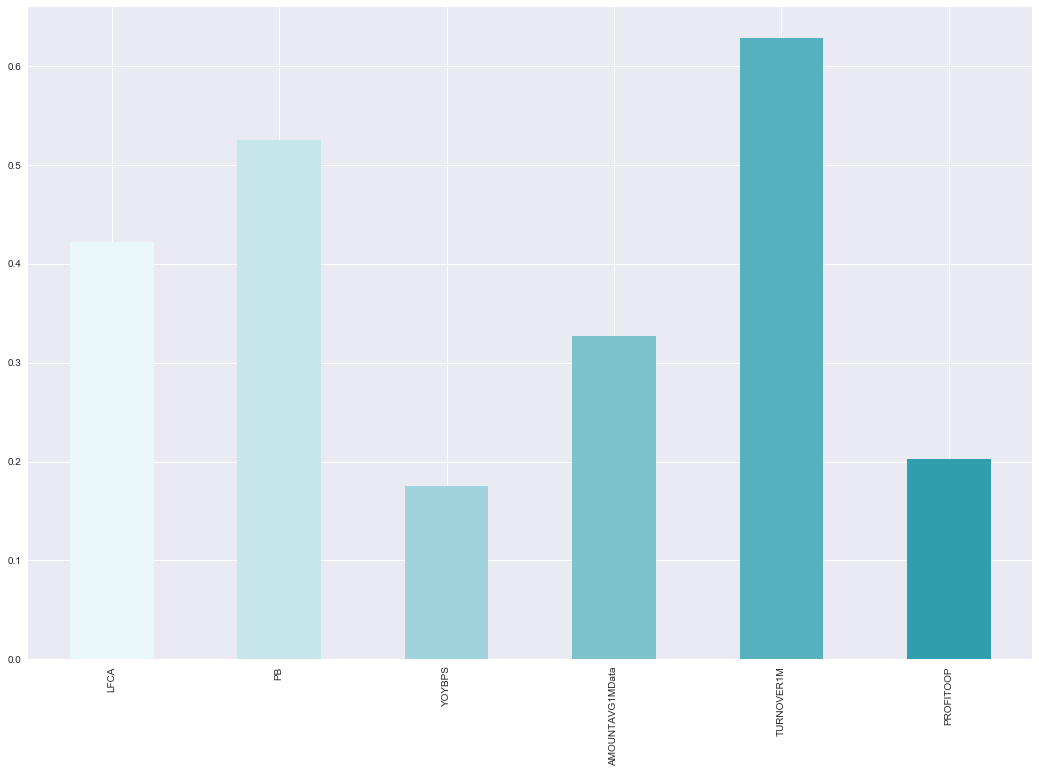

In [898]:
color_set=sns.light_palette((210, 90, 60), input="husl")
(factorPvalue[factorPvalue < 0.05].count()/len(factorPvalue)).plot(figsize=(18,12),kind='bar',color=sns.color_palette(color_set,10))

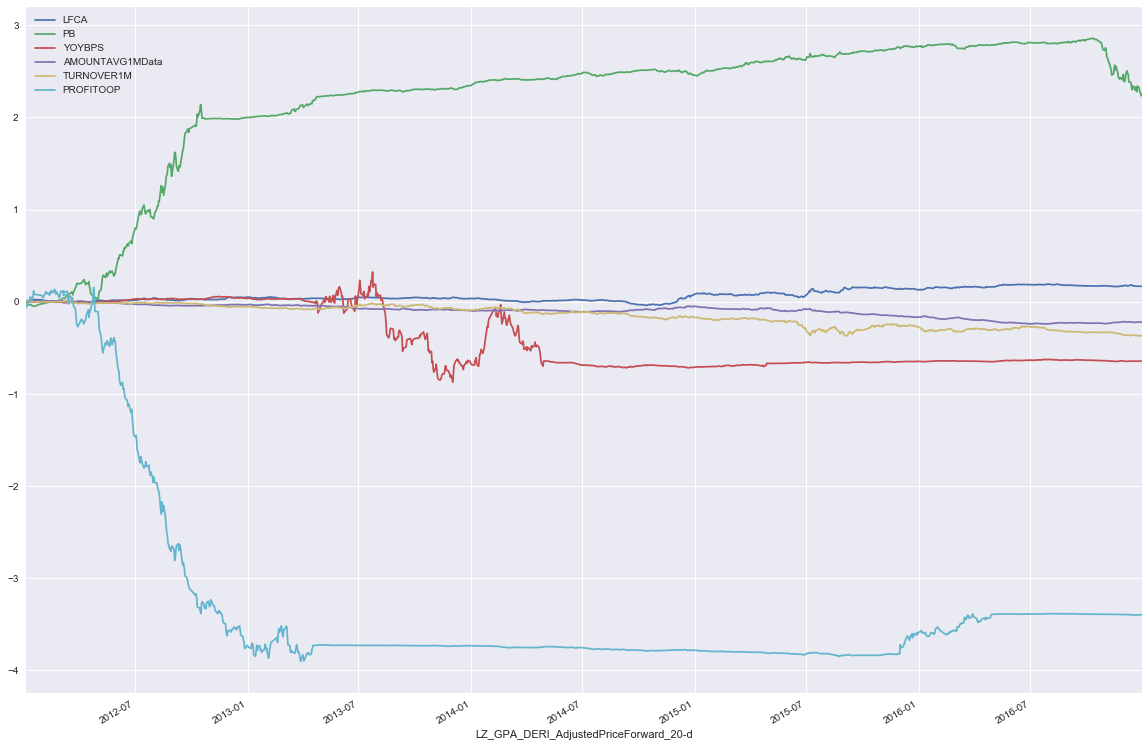

In [899]:
factorReturn.cumsum().plot(figsize=(20,14))

In [900]:
factorReturn.describe()

,LFCA,PB,YOYBPS,AMOUNTAVG1MData,TURNOVER1M,PROFITOOP
count,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000
mean,0.000138,0.001844,-0.000530,-0.000184,-0.000306,-0.002801
std,0.003104,0.018440,0.023450,0.001884,0.004886,0.026907
min,-0.018767,-0.125414,-0.164897,-0.008586,-0.025073,-0.214040
25%,-0.001447,-0.001921,-0.001335,-0.001211,-0.002268,-0.001897
50%,-0.000213,0.000765,-0.000054,-0.000234,-0.000122,-0.000158
75%,0.001137,0.003673,0.001293,0.000902,0.001962,0.000922
max,0.023949,0.167757,0.166722,0.007942,0.022233,0.134320


In [901]:
result2 = sm.OLS(factorReturn['PB'],factorReturn['LFCA']).fit()

In [912]:
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PB   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6427
Date:                Tue, 28 Mar 2017   Prob (F-statistic):              0.423
Time:                        17:43:17   Log-Likelihood:                 3117.4
No. Observations:                1213   AIC:                            -6233.
Df Residuals:                    1212   BIC:                            -6228.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
LFCA          -0.1373      0.171     -0.802      0.423      -0.473       0.199
==============================================================================
Omnibus:                      527.552   Durbin-Watson:                   1.762
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18260.947
Skew:                           1.346   Prob(JB):                         0.00
Kurtosis:                      21.816   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [903]:
specificReturn

,600507.SH,002344.SZ,000793.SZ,300039.SZ,600059.SH,600501.SH,000713.SZ,002233.SZ,600360.SH,600565.SH,...,600150.SH,600469.SH,600282.SH,600739.SH,600406.SH,600687.SH,600866.SH,000860.SZ,601908.SH,002195.SZ
LZ_GPA_DERI_AdjustedPriceForward_20-d,,,,,,,,,,,,,,,,,,,,,
2012-01-05,0.025697,-0.003473,0.037548,0.008942,-0.016753,-0.008695,-0.063853,-0.037907,0.003391,0.043417,...,-0.006358,0.025833,0.017931,0.015733,0.014046,0.047862,-0.010460,-0.016782,-0.034919,-0.028392
2012-01-06,0.009798,-0.002888,-0.014238,-0.001026,0.008056,0.008517,-0.076295,0.035727,0.012290,0.042267,...,0.007569,0.025505,0.007684,0.032604,0.004787,-0.002140,-0.026344,-0.000980,0.006110,0.020084
2012-01-09,-0.002461,-0.003983,-0.008909,0.008975,-0.001940,0.004854,-0.009167,0.023284,0.001697,-0.023664,...,0.002377,-0.014051,-0.012760,0.004765,-0.013658,-0.037539,0.002730,0.019514,0.008411,-0.039856
2012-01-10,-0.006802,-0.005576,-0.014090,-0.018444,-0.002437,-0.000083,0.061007,0.024528,-0.000246,-0.021472,...,-0.000986,0.005041,0.000619,-0.019920,-0.011203,-0.040650,0.030107,-0.000083,0.021606,0.021836
2012-01-11,0.045727,0.012534,-0.004739,-0.021131,-0.011484,0.000325,0.017528,-0.022103,-0.006171,-0.014216,...,-0.007070,0.005366,0.003864,-0.006986,0.004961,-0.005496,-0.012906,-0.007782,-0.008659,0.094104
2012-01-12,-0.009627,-0.009251,-0.003969,-0.016977,-0.002378,0.007948,-0.016876,0.007746,0.001761,-0.001463,...,0.000756,-0.014743,-0.005369,-0.002584,-0.018490,0.001313,-0.001444,-0.005423,0.036530,-0.017246
2012-01-13,-0.010242,0.020971,-0.002325,-0.040364,-0.000066,0.000146,0.017963,-0.008312,-0.005817,0.007578,...,-0.004806,-0.007751,0.008292,0.002108,-0.022852,0.039016,-0.015669,-0.015496,0.032646,-0.026735
2012-01-16,0.020199,-0.021680,0.007342,-0.001592,-0.010316,-0.006682,0.018280,-0.001341,0.008870,0.003953,...,0.005323,0.008468,0.018731,0.021012,-0.070429,0.035611,-0.011880,0.010993,-0.011707,-0.003665
2012-01-17,-0.054877,-0.000032,-0.011085,-0.017507,0.003734,-0.005410,0.000674,0.026957,0.001241,-0.006605,...,0.004167,0.006175,0.001763,0.006243,-0.022848,-0.051361,0.002953,-0.003269,0.002274,0.025791


In [904]:
result1 = sm.OLS(returnOfBench, factorReturn).fit()

In [911]:
result1 .summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              000905.SH   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     336.2
Date:                Tue, 28 Mar 2017   Prob (F-statistic):          2.15e-253
Time:                        17:21:37   Log-Likelihood:                 3696.9
No. Observations:                1213   AIC:                            -7382.
Df Residuals:                    1207   BIC:                            -7351.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
LFCA               -0.8877      0.110     -8.092      0.000      -1.103      -0.672
PB                 -0.0405      0.022     -1.871      0.062      -0.083       0.002
YOYBPS             -0.0398      0.015     -2.708      0.007      -0.069      -0.011
AMOUNTAVG1MData     0.9825      0.191      5.140      0.000       0.607       1.357
TURNOVER1M          3.0035      0.074     40.779      0.000       2.859       3.148
PROFITOOP           0.0772      0.015      5.298      0.000       0.049       0.106
==============================================================================
Omnibus:                       77.444   Durbin-Watson:                   1.694
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              306.322
Skew:                          -0.130   Prob(JB):                     3.04e-67
Kurtosis:                       5.448   Cond. No.                         17.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [913]:
result1.resid.head(10)

LZ_GPA_DERI_AdjustedPriceForward_20-d
2012-01-05   -0.030171
2012-01-06   -0.001059
2012-01-09    0.032445
2012-01-10    0.041967
2012-01-11    0.000153
2012-01-12   -0.000846
2012-01-13   -0.028417
2012-01-16   -0.024800
2012-01-17    0.050525
2012-01-18   -0.021567
dtype: float64

In [908]:
print PBData.shape,YOYBPSData.shape,AMOUNTAVG1MData .shape, TURNOVER1MData.shape,PROFITOOPData.shape

(1214, 1071) (1214, 1071) (1214, 1071) (1214, 1071) (1214, 1071)


In [909]:
# 
#stDF = pd.read_csv(path+filenameST,infer_datetime_format=True,parse_dates=[0],index_col=0)[-timeStampNum-1:-5]
#tradeDayDF = pd.read_csv(path+filenameTradeday,infer_datetime_format=True,parse_dates=[0],index_col=0)[-timeStampNum-1:-5]
#stopFlagDF = pd.read_csv(path+filenameStopFlag,infer_datetime_format=True,parse_dates=[0],index_col=0)[-timeStampNum-1:-5]

In [910]:
# Generate the useles stock list
filterdict={}
for i in endOfMonthList:
    suspendList = ff.GetSTNewSuspend(i,stDF,tradeDayDF,stopFlagDF)
    filterdict[i] = suspendList
    print i, len(filterdict[i])

NameError: name 'endOfMonthList' is not defined

In [ ]:
# prepare data
